# Golf Swing Analysis
This project aims to develop a robust golf swing tracker that can track the path of the club through the different stages of the swing.

## 1. Read in the required packages for the program.

In [1]:
from pathlib import Path
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import glob

## 2. Data Input and Manipulation.
1. Reading input videos  
2. Splitting into frames.

**Directory Setup:**  
Setting the input / output directories for the program.  

In [2]:
vid_dir = Path('Videos')
frames_dir = Path('Frames')
processed_dir = Path('Processed')
blurred_dir = Path('Processed/Blurred')
FGMask_dir = Path('Processed/FGMask')
EdgesContours_dir = Path('Processed/EdgesContours')

# Make the directories if not already in existance
if not vid_dir.exists():
    vid_dir.mkdir()
if not frames_dir.exists():
    frames_dir.mkdir()
if not processed_dir.exists():
    processed_dir.mkdir()
if not blurred_dir.exists():
    blurred_dir.mkdir()
if not FGMask_dir.exists():
    FGMask_dir.mkdir()
if not EdgesContours_dir.exists():
    EdgesContours_dir.mkdir()

**Extract Frames function:**  
Extracts frames from a video and saves them in a folder with the same name as the video.  

        Args:  
            video_path: Path to the video file.  
        Returns:  
            None  

In [3]:
def extract_frames():
    count = 0
    # Loop through each video file
    for video_file in vid_dir.glob('*.mp4'):
        video_path = str(video_file)
        
        if count == 3:
            break
        count += 1
        # Check if the path is a file
        if video_file.is_file():
            # Open the video file and get filename for frame naming
            cap = cv2.VideoCapture(video_path)
            video_name = Path(video_file).stem
            
            # Loop through the video frame by frame
            frame_count = 0
            while True:
                ret, frame = cap.read()          
                if not ret:
                    break
                    
                # Construct the name of the frame file and same as image
                frame_file = f"{video_name}_frame{frame_count}.png"
                frame_path = str(frames_dir / frame_file)
                cv2.imwrite(frame_path, frame)
                
                frame_count += 1        
            cap.release()
    print("Frame extraction complete.")

In [4]:
extract_frames()

Frame extraction complete.


## 3. Preprocessing the frames.
1. Apply Gaussian Blur to the frames.
2. Normalise the intensity values of the frames.
3. Apply background subtraction to the frames.

**Process Frames function:**  
Processes the frames extracted from the videos by applying:   
1. Gaussian blur to reduce noise in the images.  
2. Normalising the input values.  

        Args:  
            None  
        Returns:  
            None  

In [4]:
def process_frames():
    # Iterate over each frame in the frame directory
    for frame_path in frames_dir.iterdir():
        frame = cv2.imread(str(frame_path))
        blurred_frame = cv2.GaussianBlur(frame, (5, 5), 0)

        # Normalize the pixel values to [0, 1]
        normalised_frame = blurred_frame / 255.0

        blurred_frame_path = blurred_dir / f"processed_{frame_path.name}"
        cv2.imwrite(str(blurred_frame_path), normalised_frame * 255)
        
        # Print comparison of images for visualisation
        if frame_path.name == "0_frame0.png":
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            ax[0].set_title("Original")
            ax[1].imshow(cv2.cvtColor(blurred_frame, cv2.COLOR_BGR2RGB))
            ax[1].set_title("Blurred")
            ax[2].imshow(normalised_frame)
            ax[2].set_title("Normalised")
            plt.show()
    print("Frame blurring and normalising complete.")

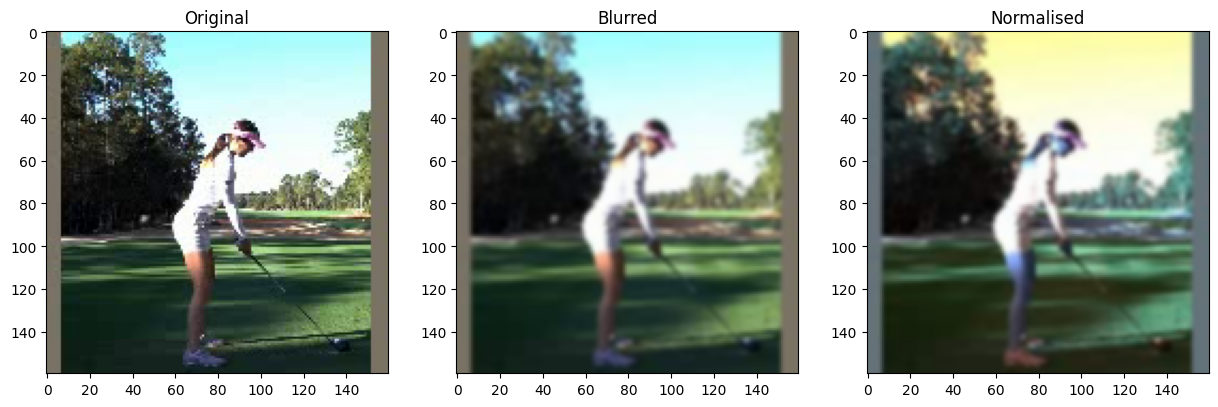

Frame blurring and normalising complete.


In [6]:
process_frames()

**Foreground Subtraction function:**  
Applies background subtraction to the frames to extract the foreground (golfer and club).  
Uses the MOG2 algorithm to perform background subtraction and the proceeds to apply morphological transformations to the image to remove noise using erode and dilate.

        Args:  
            None  
        Returns:  
            None  

In [5]:
def fg_subtraction():
    # Foreground object (golf club) is moving and background is static
    bg_subtractor = cv2.createBackgroundSubtractorMOG2()

    # Iterate over pre-processed frames
    for blurred_frame_path in blurred_dir.iterdir():
        frame = cv2.imread(str(blurred_frame_path))
        
        # Apply background subtraction
        fg_mask = bg_subtractor.apply(frame)
        
        # Noise Reduction: Erode and Dilate
        fg_mask = cv2.erode(fg_mask, None, iterations=1)
        fg_mask = cv2.dilate(fg_mask, None, iterations=2)

        fg_mask_output_path = FGMask_dir / f"fgmask_{blurred_frame_path.name}"
        cv2.imwrite(str(fg_mask_output_path), fg_mask)
    print("Foreground subtraction complete.")

In [8]:
fg_subtraction()

Foreground subtraction complete.


**Foreground Subtraction Comparisons**  
Input vs output frames, visualised as a gif with blurred input on the left and foreground masked output on the right.  
Video 0:  
![SegmentLocal](Gifs\Blurred0.gif "segment")  ![SegmentLocal](Gifs\FGMask0.gif "segment")  
  
Video 1:  
![SegmentLocal](Gifs\Blurred1.gif "segment")  ![SegmentLocal](Gifs\FGMask1.gif "segment")  

Video 10:  
![SegmentLocal](Gifs\Blurred10.gif "segment")  ![SegmentLocal](Gifs\FGMask10.gif "segment")  

## 4. Object Detection
This section focuses on detecting the club head within each frame.
1. Apply Canny Edge Detection to the frames.
2. Find contours in the frames.
3. Bound the contours with a rectangle.
4. Visualise the rectangle on the frame.

**Apply Edge Detection function**  
Convert the frame to grayscale if not already in grayscale.
Applies Canny Edge Detection to the frame to extract the edges of the foreground objects.

        Args:  
            frame: Input frame to apply edge detection to.
            lower_threshold: Lower threshold for the Canny Edge Detection algorithm.
            upper_threshold: Upper threshold for the Canny Edge Detection algorithm.  
        Returns:  
            edges: Output frame with the edges of the foreground objects.

In [44]:
def apply_edge_detection(frame, lower_threshold=50, upper_threshold=150):
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) if len(frame.shape) == 3 else frame
    # Apply Canny edge detection
    edges = cv2.Canny(gray_frame, lower_threshold, upper_threshold)
    return edges

**Filter Contours by Position function**  
Filters out the golfers body by excluding contours that are within the centre of the frame
    
            Args:  
                contours: List of contours to filter.
                frame_shape: Shape of the frame to determine the centroid.  
            Returns:  
                filtered_contours: List of contours that are not within the centre of the frame.

In [42]:
def filter_contours_by_position(contours, frame_shape):
    filtered_contours = []
    
    h, w, _ = frame_shape
    
    # Assuming the golfer's body is in the center of the frame
    exclude_center = {
        "left_top": (h * 0.25, w * 0.35),
        "right_bottom": (h * 0.75, w * 0.65)
    }
    
    for cnt in contours:
        # Calc centroid of the contour
        M = cv2.moments(cnt)
        if M["m00"] != 0:  # Division by zero
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            
            # Check if centroid is outside the excluded region
            if (
                cY < exclude_center["left_top"][0] or 
                cY > exclude_center["right_bottom"][0] or
                cX < exclude_center["left_top"][1] or
                cX > exclude_center["right_bottom"][1]
            ):
                filtered_contours.append(cnt)
    return filtered_contours

**Find Golf Club function**  
*Tries* to find the golf club head in the frame by finding the *best* contour in the frame and then fitting a rectangle around it.
It calls the filter_contours_by_position function to filter out contours that are expected to be the golfers body. Assuming that the golf club will be roughly within the top-left to bottom-right diagonal of the frame, the function will only consider contours that are within this region. It also exludes the top right and bottom left 20% of the frame as the club is unlikely to be in these regions. It preers contours that are close to the bounding box of the previous frame.

        args:  
            edges: Input frame with the edges of the foreground objects.
            frame: Input frame for the filter_contours_by_position function.
            previous_bbox: Bounding box of the previous frame.
        returns:
            best_contour: The contour that is most likely to be the golf club head.
            previous_bbox: Bounding box of the best contour.

In [43]:
def find_golf_club_contour(edges, frame, previous_bbox=None):
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter out contours that are within the exclusion zone (like the golfer's body)
    filtered_contours = filter_contours_by_position(contours, frame.shape)

    potential_contours = []
    for contour in filtered_contours:
        # ... (rest of your code remains the same)

        # Aspect Ratio Filtering
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w)/h
        
        # Acceptable deviation from the diagonal 
        diagonal_deviation = 0.3 * edges.shape[1] 
        
        # Conditions for exclusion zones (bottom left corner 20% and top right corner 20%)
        exclude_bottom_left = x < 0.2 * edges.shape[1] and y > 0.8 * edges.shape[0]
        exclude_top_right = x > 0.8 * edges.shape[1] and y < 0.2 * edges.shape[0]
        
        # Check if contour is approximately along the diagonal and not in exclusion zones
        if (
            2 < aspect_ratio < 6 and
            not exclude_bottom_left and
            not exclude_top_right and
            abs(x - y * (edges.shape[1] / edges.shape[0])) < diagonal_deviation
        ):
            potential_contours.append(contour)
           
    # If previous_bbox is provided, prefer contours that are close to the previous position
    if previous_bbox is not None and potential_contours:
        prev_x, prev_y, _, _ = previous_bbox
        potential_contours.sort(key=lambda cnt: abs(cv2.boundingRect(cnt)[0] - prev_x) +
                                             abs(cv2.boundingRect(cnt)[1] - prev_y))
    
    # Select the best contour based on the applied filters and checks
    best_contour = potential_contours[0] if potential_contours else None
    
    # If a contour is found, extract its bounding box and do further processing
    if best_contour is not None:
        x, y, w, h = cv2.boundingRect(best_contour)
        previous_bbox = (x, y, w, h)
        
    return best_contour, previous_bbox

**Get Bounding Box function**  
Finds the bounding box of the contour and returns it.

        args:
            contour: Contour to find the bounding box of.
        returns:
            bbox: Bounding box of the contour.

In [ ]:
def get_bounding_box(contour):
    # Get bounding box around the detected object
    if contour is not None:
        x, y, w, h = cv2.boundingRect(contour)
        return (x, y, w, h)
    return None

**Visualise Detection function**
Draws the bounding box on the frame and displays it.

        args:
            frame: Input frame to draw the bounding box on.
            bbox: Bounding box to draw on the frame.
        returns:
            None

In [46]:
def visualise_detection(original_frame, bounding_box=None):
    visualization_frame = original_frame.copy()
    if bounding_box is not None:
        x, y, w, h = bounding_box
        cv2.rectangle(visualization_frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
    return visualization_frame

**Fine Edge and Contour function**
Simple wrapper function to call all of the above functions for each frame in each video.

        args:
            None
        returns:
            None

In [47]:
def findedgeandcontour(path_coords):
    previous_bbox = None
    
    for fg_mask_frame_path in FGMask_dir.iterdir():
        frame = cv2.imread(str(fg_mask_frame_path))
        edges = apply_edge_detection(frame)
        contour, previous_bbox = find_golf_club_contour(edges, frame, previous_bbox)
        bounding_box = get_bounding_box(contour)
        finished_frame = visualise_detection(frame, bounding_box)
        
        # Plot the image for visualisation
        if fg_mask_frame_path.name == "fgmask_processed_0_frame60.png":
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            ax[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            ax[0].set_title("Original")
            ax[1].imshow(edges, cmap="gray")
            ax[1].set_title("Edges")
            ax[2].imshow(finished_frame, cmap="gray")
            ax[2].set_title("Contours")
            plt.show()
        edges_contours_output_path = EdgesContours_dir / f"edges_contours_{fg_mask_frame_path.name}"
        cv2.imwrite(str(edges_contours_output_path), finished_frame)
    print("Edge detection and contouring complete.")
    return path_coords

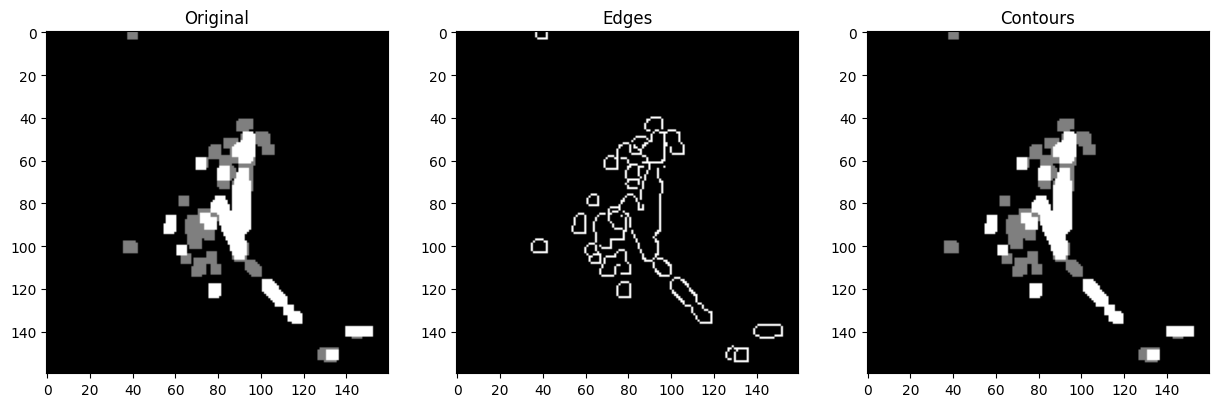

Edge detection and contouring complete.


In [38]:
path_coords = {}
findedgeandcontour(path_coords)

Video 0: &emsp;&emsp;&emsp;&ensp; Video1: &emsp;&emsp;&emsp;&ensp;&nbsp; Video10: &emsp;  
![SegmantLocal](Gifs\EdgesContours0.gif "segment") ![SegmentLocal](Gifs\EdgesContours1.gif "segment")  ![SegmentLocal](Gifs\EdgesContours10.gif "segment")

### 4. Object Tracking
1. Initialise the tracker.
2. Update the tracker with the new frame.
3. Record position of the club head in each frame.

### 5. Path Visualisation
1. Plot the path of the club head in each frame.
2. Overlay the path on the original video.
3. Create the output video.

**Creating gifs for the output videos**

In [48]:
# bg0 = [Image.open(filename) for filename in glob.glob('Processed/Blurred/*_0_*.png')]
# bg0[0].save('Gifs/Blurred0.gif', save_all=True, append_images=bg0[1:], optimize=False, duration=40, loop=0)
# fg0 = [Image.open(filename) for filename in glob.glob('Processed/FGMask/*_*_0_*.png')]
# fg0[0].save('Gifs/FGMask0.gif', save_all=True, append_images=fg0[1:], optimize=False, duration=40, loop=0)
eg0 = [Image.open(filename) for filename in glob.glob('Processed/EdgesContours/*_*_0_*.png')]
eg0[0].save('Gifs/EdgesContours0.gif', save_all=True, append_images=eg0[1:], optimize=False, duration=40, loop=0)

# bg1 = [Image.open(filename) for filename in glob.glob('Processed/Blurred/*_1_*.png')]
# bg1[0].save('Gifs/Blurred1.gif', save_all=True, append_images=bg1[1:], optimize=False, duration=40, loop=0)
# fg1 = [Image.open(filename) for filename in glob.glob('Processed/FGMask/*_*_1_*.png')]
# fg1[0].save('Gifs/FGMask1.gif', save_all=True, append_images=fg1[1:], optimize=False, duration=40, loop=0)
ec1 = [Image.open(filename) for filename in glob.glob('Processed/EdgesContours/*_*_1_*.png')]
ec1[0].save('Gifs/EdgesContours1.gif', save_all=True, append_images=ec1[1:], optimize=False, duration=40, loop=0)

# bg10 = [Image.open(filename) for filename in glob.glob('Processed/Blurred/*_10_*.png')]
# bg10[0].save('Gifs/Blurred10.gif', save_all=True, append_images=bg10[1:], optimize=False, duration=40, loop=0)
# fg10 = [Image.open(filename) for filename in glob.glob('Processed/FGMask/*_*_10_*.png')]
# fg10[0].save('Gifs/FGMask10.gif', save_all=True, append_images=fg10[1:], optimize=False, duration=40, loop=0)
ec10 = [Image.open(filename) for filename in glob.glob('Processed/EdgesContours/*_*_10_*.png')]
ec10[0].save('Gifs/EdgesContours10.gif', save_all=True, append_images=ec10[1:], optimize=False, duration=40, loop=0)